# Z2 lattice gauge theory

In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

### Create a circuit with as many modes as qubits

In [3]:
numberofmodes=2
numberofqubitspermode=1
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=1)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [4]:
diffstallmodes=[1,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

In [5]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    # circuit.rx(-2*g*dt, qb)
    return circuit

In [6]:
dt=1
m=1
g=1
N=5

circuit.h(qbr[0]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1")
    eiht(circuit, qmr[0], qmr[1], qbr[0], m, g, dt)
    stateop, _ = c2qa.util.simulate(circuit)
    util.stateread(stateop, qbr.size, numberofmodes, cutoff)

qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  0.7071067811865475
dt+1
qumodes:  01  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  -0.7071067811865475
dt+1
qumodes:  10  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  -0.7071067811865475
dt+1
qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  0.7071067811865475


/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [7]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  20  qubits:  0     with amplitude:  -1.0
Counts(ideal): {'0': 516, '1': 508}


### Create a circuit with as many modes as qubits

In [27]:
numberofqubits=2
numberofmodes=3
numberofqubitspermode=1
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [28]:
diffstallmodes=[0,1,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

In [29]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-2*g*dt, qb)
    return circuit

qumodes:  010  qubits:  00     with amplitude:  0.7071067811865476
qumodes:  010  qubits:  01     with amplitude:  0.7071067811865475
dt+1
dt+1
dt+1
dt+1
dt+1


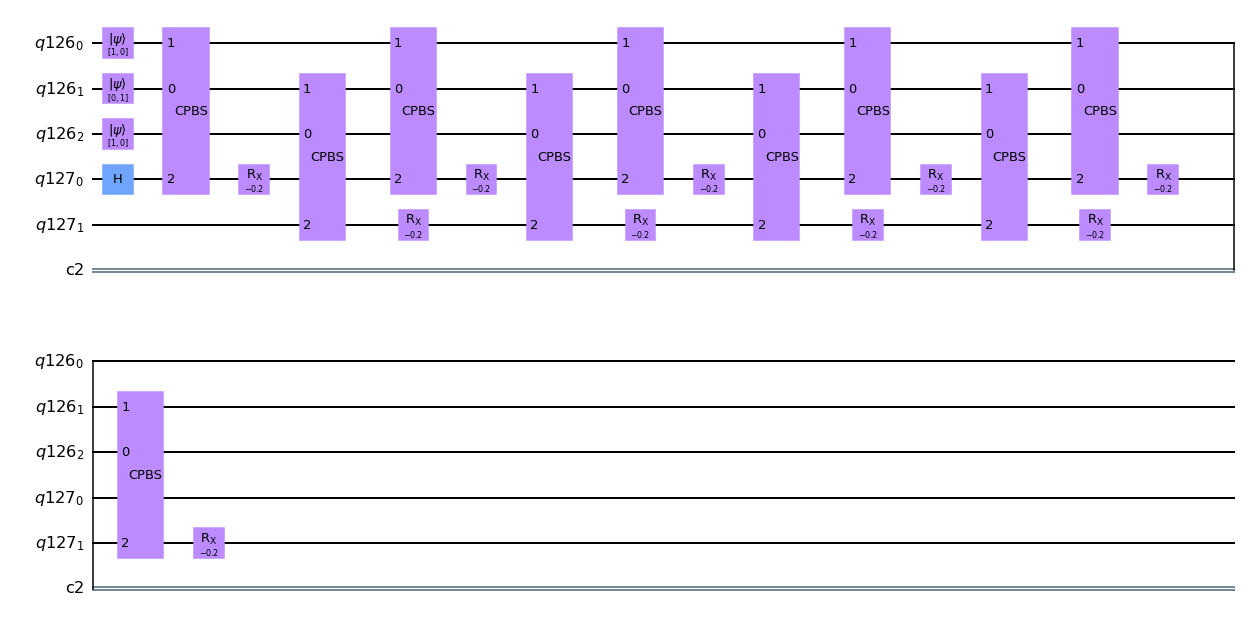

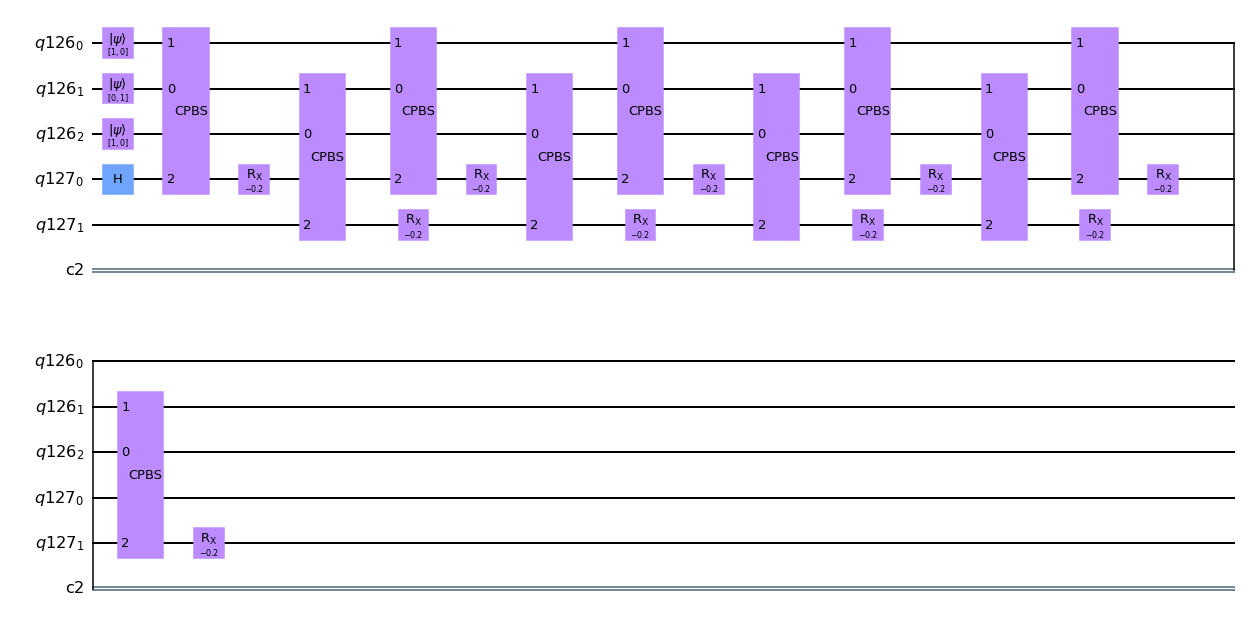

In [30]:
dt=1
m=1
g=0.1
N=5

circuit.h(qbr[0]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1")
    for j in range(0,numberofmodes-1,2):
        eiht(circuit, qmr[j], qmr[j+1], qbr[j], m, g, dt)
    for j in range(1,numberofmodes-1,2):
        eiht(circuit, qmr[j], qmr[j+1], qbr[j], m, g, dt)


circuit.draw(output='mpl', filename='lgt_circuit.png')

In [31]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  200  qubits:  01     with amplitude:  0.9900332889206207
qumodes:  200  qubits:  11     with amplitude:  0.009966711079379182
Counts(ideal): {'0': 520, '1': 504}
